In [ ]:
import torch
import torch.nn as nn

class Discriminator(nn.Module):
    def __init__(self, img_ch):
        super(Discriminator, self).__init__()
        self.discriminate = nn.Sequential(
            nn.Conv2d(img_ch, 64, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(64, 128, 4, 2, 1, bias=False),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(128, 256, 4, 2, 1, bias=False),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(256, 512, 4, 2, 1, bias=False),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(512, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
        )
    
    def forward(self, input):
        return self.discriminate(input).view(-1)


class Generator(nn.Module):
    def __init__(self, in_channel, img_ch):
        super(Generator, self).__init__()
        self.generate = nn.Sequential(
            nn.ConvTranspose2d(in_channel, 512, 4, 1, 0, bias=False),
            nn.BatchNorm2d(512),
            nn.ReLU(True),
            nn.ConvTranspose2d(512, 256, 4, 2, 1, bias=False),
            nn.BatchNorm2d(256),
            nn.ReLU(True),
            nn.ConvTranspose2d(256, 128, 4, 2, 1, bias=False),
            nn.BatchNorm2d(128),
            nn.ReLU(True),
            nn.ConvTranspose2d(128, 64, 4, 2, 1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(True),
            nn.ConvTranspose2d(64, img_ch, 4, 2, 1, bias=False),
            nn.Tanh()
        )
  
    def forward(self, input):
        return self.generate(input)



In [ ]:
import os
import time
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

import torch.utils.data as data
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as transforms
from torchvision.datasets import CIFAR10

class Network():
    def __init__(self, latent_dims=64, num_epochs=25, batch_size=64, learning_rate=2.0e-4, dataset='mnist', gpu=True):
        self.latent_dims = latent_dims
        self.num_epochs = num_epochs
        self.batch_size = batch_size
        self.in_channel = 100
        self.learning_rate = learning_rate
        self.gpu = gpu
        self.dur_time = 0

        if dataset == 'mnist' or dataset == 'fashion_mnist':
            self.img_ch = 1
        else:
            self.img_ch = 3

        self._init_dataset()
        self._init_model()

    def _init_dataset(self):
        transform = transforms.Compose([
            transforms.Resize(64),
            transforms.ToTensor(), 
            transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
        ])

        train_data = CIFAR10(root='./dataset_cifar10', download=True, train=True, transform=transform)
        test_data = CIFAR10(root='./dataset_cifar10', download=True, train=False, transform=transform)

        self.train_queue = data.DataLoader(train_data, batch_size=self.batch_size, shuffle=True, drop_last=True)
        self.test_queue = data.DataLoader(test_data, batch_size=self.batch_size, shuffle=True, drop_last=True)
        
    def weights_init(self, m):
        classname = m.__class__.__name__
        if classname.find('Conv') != -1:
            m.weight.data.normal_(0.0, 0.02)
        elif classname.find('BatchNorm') != -1:
            m.weight.data.normal_(1.0, 0.02)
            m.bias.data.fill_(0)

    def _init_model(self):
        self.device = torch.device('cuda' if (torch.cuda.is_available() & self.gpu) else 'cpu')

        Gen = Generator(self.in_channel, self.img_ch).to(self.device)
        Dis = Discriminator(self.img_ch).to(self.device)
        self.Gen = Gen.to(self.device)
        self.Dis = Dis.to(self.device)
        
        self.Gen.apply(self.weights_init)
        self.Dis.apply(self.weights_init)
        
        self.criterion = nn.BCELoss()

        #self.optimizer = torch.optim.Adam(params=self.model.parameters(), lr=self.learning_rate, weight_decay=1e-5)
        self.G_optimizer = optim.Adam(self.Gen.parameters(), lr=self.learning_rate, betas=(0.5, 0.999))    # optimizer
        self.D_optimizer = optim.Adam(self.Dis.parameters(), lr=self.learning_rate, betas=(0.5, 0.999))

    def show_images(self, images, num_images=16):
        #sqrtn = int(np.ceil(np.sqrt(images.shape[0])))
        images = images.permute(0, 2, 3, 1)
        images = np.array(images)
        #print(images)  
        sqrtn = int(np.ceil(np.sqrt(num_images)))

        for index, image in enumerate(images):
            if index < num_images:
                #print(image.shape)
                plt.subplot(sqrtn, sqrtn, index+1)    
                plt.imshow(image)
                plt.axis('off')


    def calc_time(self, seconds):
        m, s = divmod(seconds, 60)
        h, m = divmod(m, 60)
        t, h = divmod(h, 24)
        return {'day':t, 'hour':h, 'minute':m, 'second':int(s)}
    

    def train_cifar10(self):
        G_loss_list = []
        D_loss_list = []
        run_start = time.time()

        self.Gen.train()
        self.Dis.train()
        for epoch in range(self.num_epochs):
            G_loss_sum = 0
            D_loss_sum = 0

            show_inputs = None
            show_outputs = None
            for step, (inputs, _) in enumerate(self.train_queue):
                # Train Disciminator For Real Image
                self.Dis.zero_grad()

                inputs_real = inputs.to(self.device) # 64,1,28,28
                real_label = torch.ones(self.batch_size,).to(self.device) # 64個1，代表真實的圖片
                inputs_real_predict = self.Dis(inputs_real)

                #print(inputs_real_predict.shape, real_label.shape)
                D_real_loss = self.criterion(inputs_real_predict, real_label) # view make [64,1,1,1] -> [64] and cal loss
                D_real_loss.backward()

                # Train Disciminator For Fake Image
                noise = torch.tensor(torch.randn(self.batch_size, self.in_channel, 1, 1, device=self.device)) # torch.Size([64, 100, 1, 1])
                fake_label = torch.zeros(self.batch_size,).to(self.device)   # 64個0，代表假的圖片
                fake_out = self.Gen(noise)                   # 64,1,28,28
                fake_predict = self.Dis(fake_out.detach())               # 64,1,1,1
                
                #print(fake_predict.shape, fake_label.shape)
                D_fake_loss = self.criterion(fake_predict, fake_label) # view make [64,1,1,1] -> [64] and cal loss
                D_fake_loss.backward()

                D_total_loss = D_real_loss + D_fake_loss
                D_loss_list.append(D_total_loss.item())
                D_loss_sum += D_total_loss
                self.D_optimizer.step()

                self.Gen.zero_grad()

                # 訓練生成真實圖片
                #noise = torch.tensor(torch.randn(self.batch_size, self.in_channel, 1, 1, device=self.device)) # torch.Size([64, 100, 1, 1])
                target_label = torch.ones(self.batch_size,).to(self.device) # 64個1，代表希望產生的真實圖片
                #fake_out2 = self.Gen(noise)      # 生成假圖片
                fake_predict2 = self.Dis(fake_out)  # 獲得Discriminator的判斷

                G_loss = self.criterion(fake_predict2, target_label)
                G_loss_list.append(G_loss.item())
                G_loss_sum += G_loss
                G_loss.backward()
                self.G_optimizer.step()

                show_outputs = fake_out.detach().cpu()

            trainG_avg_loss = G_loss_sum/step
            trainD_avg_loss = D_loss_sum/step
            print('Epoch [{}]/[{}], D Loss:{}, G Loss:{}'.format(epoch, self.num_epochs, trainD_avg_loss, trainG_avg_loss))
            print('cost time: {}'.format(self.calc_time(self.dur_time + time.time() - run_start)))

            #if epoch == self.num_epochs-1:
            #self.show_images(show_inputs)
            #plt.savefig('inputs_fashion_'+str(self.latent_dims)+'.png')
            #plt.show()
            self.show_images(show_outputs)
            plt.savefig('outputs_cifar10.png')
            plt.show()

        plt.subplot(211)
        plt.plot(G_loss_list)
        plt.subplot(212)
        plt.plot(D_loss_list)

        torch.save(self.Gen, './DCGAN_Generator_cifar10.pth')
        torch.save(self.Dis, './DCGAN_Discriminator_cifar10.pth')

Files already downloaded and verified
Files already downloaded and verified


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:117: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for fl

Epoch [0]/[25], D Loss:0.5277639031410217, G Loss:6.943708419799805
cost time: {'day': 0.0, 'hour': 0.0, 'minute': 4.0, 'second': 48}


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


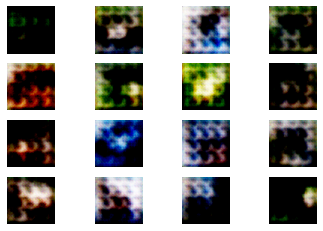

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch [1]/[25], D Loss:0.6358634829521179, G Loss:4.065782070159912
cost time: {'day': 0.0, 'hour': 0.0, 'minute': 9.0, 'second': 38}


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

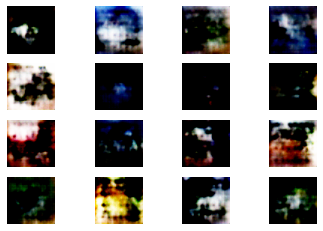

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

Epoch [2]/[25], D Loss:0.6852681040763855, G Loss:3.3626606464385986
cost time: {'day': 0.0, 'hour': 0.0, 'minute': 14.0, 'second': 29}


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


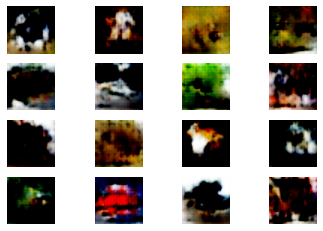

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch [3]/[25], D Loss:0.7596834897994995, G Loss:2.9810214042663574
cost time: {'day': 0.0, 'hour': 0.0, 'minute': 19.0, 'second': 19}


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


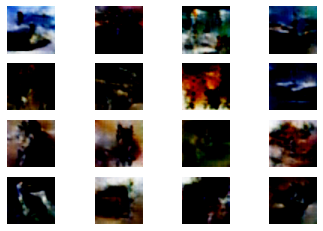

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch [4]/[25], D Loss:0.7977704405784607, G Loss:2.7114193439483643
cost time: {'day': 0.0, 'hour': 0.0, 'minute': 24.0, 'second': 9}


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


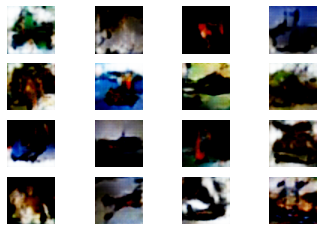

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch [5]/[25], D Loss:0.7311062216758728, G Loss:2.7671289443969727
cost time: {'day': 0.0, 'hour': 0.0, 'minute': 28.0, 'second': 59}


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


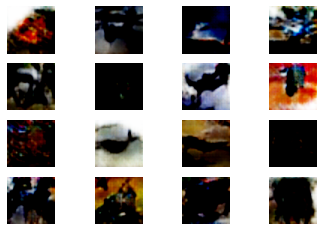

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch [6]/[25], D Loss:0.7034091353416443, G Loss:3.1103625297546387
cost time: {'day': 0.0, 'hour': 0.0, 'minute': 33.0, 'second': 50}


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


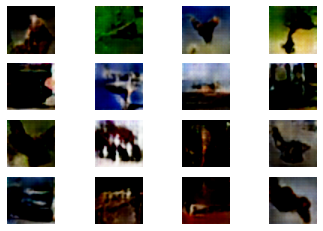

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch [7]/[25], D Loss:0.6473107933998108, G Loss:3.3450074195861816
cost time: {'day': 0.0, 'hour': 0.0, 'minute': 38.0, 'second': 40}


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


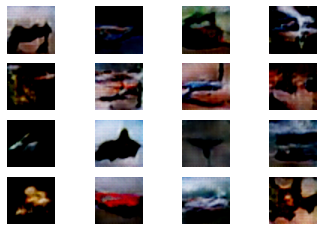

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch [8]/[25], D Loss:0.6043025851249695, G Loss:3.599144697189331
cost time: {'day': 0.0, 'hour': 0.0, 'minute': 43.0, 'second': 31}


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


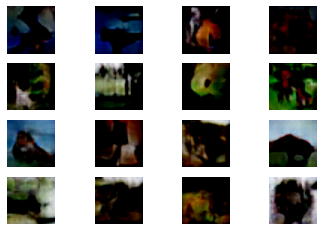

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch [9]/[25], D Loss:0.6899438500404358, G Loss:3.1717329025268555
cost time: {'day': 0.0, 'hour': 0.0, 'minute': 48.0, 'second': 21}


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

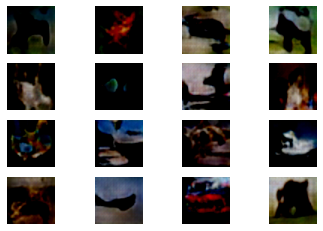

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch [10]/[25], D Loss:0.5925400257110596, G Loss:3.601264238357544
cost time: {'day': 0.0, 'hour': 0.0, 'minute': 53.0, 'second': 11}


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


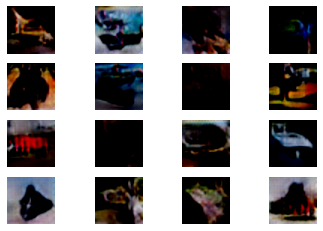

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch [11]/[25], D Loss:0.5954107046127319, G Loss:3.6577951908111572
cost time: {'day': 0.0, 'hour': 0.0, 'minute': 58.0, 'second': 1}


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


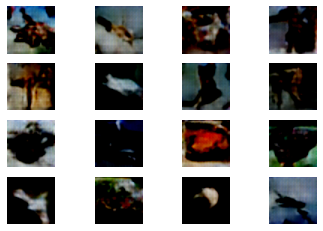

In [ ]:
if __name__ == '__main__':
    train_network = Network(dataset='cifar10')
    train_network.train_cifar10()